In [1]:
%matplotlib inline

In [2]:
# Standard Python packages
import toml
import numpy as np
import matplotlib.pyplot as plt

# Workflow management.
import salvus_flow.api

# Specific objects to aid in setting up simulations.
from pyasdf import ASDFDataSet
from salvus_mesh.simple_config import basic_mesh
from salvus_flow.simple_config import (
    CartesianVectorSource2D, CartesianReceiver2D, RickerSTF,
    WaveformSimulation, AbsorbingBoundary)

In [12]:
import h5py

In [3]:
# Domain setup (m).
max_x = 2000.0 # Distance in meters.
max_y = 1000.0 # Distance in meters.
max_frequency = 25.0 # Frequency in Hz.

# Material properties.
vp  = 3200.0 # P-wave velocity in m/s.
vs  = 1847.5 # S-wave velocity in m/s.
rho = 2200.0 # Density in kg / m^3.

In [4]:
from salvus_mesh import StructuredGrid2D

In [6]:
# Generate a mesh using the "simplified" meshing interface.
mesh = basic_mesh.CartesianHomogeneousIsotropicElastic2D(
    vp=vp, vs=vs, rho=rho, x_max=max_x, y_max=max_y, 
    max_frequency=max_frequency).create_mesh()

# Visualize the mesh in the notebook.
mesh

# Write the mesh to a file which can be visualized in Paraview.
# Open the associated lambs_problem_mesh.xdmf to visualize.
# mesh.write_h5_tensorized_model("lambs_problem_mesh.h5")

In [9]:
# Sources.
fx, fy = 0.0, -1e10 # Source components (Nm)
sx, sy = 1000.0, 500.0 # Source position (m)
stf = RickerSTF(center_frequency=14.5) # Center frequency in Hz.
source = CartesianVectorSource2D(
    name="source_0", x=sx, y=sy, fx=fx, fy=fy, 
    source_time_function=stf)

# Receivers.
nr = 5 # Number of receivers.
ry0 = 800.0 # Receiver y-value.
rx0 = 1010.0 # x-value of first receiver.
rx1 = 1410.0 # x-value of last receiver.
receivers = [
    CartesianReceiver2D(
        x=x, y=ry0, station_code=f"{_i:03d}", fields=["displacement"])
        for _i, x in enumerate(np.linspace(rx0, rx1, nr))]

In [10]:
# Set up a waveform simulation object.
simulation = WaveformSimulation(
    mesh=mesh, sources=source, receivers=receivers)

# Modify the start-time, end-time, and time-step of the simulation.
simulation.physics.wave_equation.end_time_in_seconds = 0.52
simulation.physics.wave_equation.time_step_in_seconds = 1e-3
simulation.physics.wave_equation.start_time_in_seconds = -0.08

# Make sure that Salvus _Compute_ will accept the current options.
simulation.validate()

In [37]:
simulation.domain.model

{'filename': '/tmp/salvus_flow_of_zn7u4/mesh.h5', 'format': 'hdf5'}

In [13]:
file1 = h5py.File('/tmp/salvus_flow_of_zn7u4/mesh.h5')

In [39]:
file1.keys()

<KeysViewHDF5 ['MODEL', 'SIDE_SETS', 'TOPOLOGY']>

In [42]:
file1['MODEL'].keys()

<KeysViewHDF5 ['coordinates', 'data', 'element_data', 'medium', 'non_duplicated_coordinates', 'non_duplicated_sub_connectivity', 'sub_connectivity']>

In [47]:
a = file1['MODEL']['data']

In [48]:
a1 = np.array(a)

In [50]:
a1.shape

(1540, 3, 4)

In [7]:
salvus_flow.api.run(
    site_name="aug04", input_file=simulation, ranks=2,
    output_folder="output", overwrite=True, get_all=True)

Job `job_1903281225_f2675` running on `aug04` with 2 rank(s).
Site information:
  * Salvus version: 0.8.2
  * Floating point size: 32



Results have been downloaded to `output`.


In [8]:
def plot_asdf_seismograms(asdf_file, axes):
    """
    A simple utility function to plot traces side-by side with a
    semi-analytic solution to Lamb's problem.
    :param asdf_file: ASDF datafile containing receivers.
    :param axes: Axes on which to plot.
    """    
    for i, waveform in enumerate(asdf_file.waveforms):
        for j, cmp in enumerate(["X", "Y"]):
            trace = waveform.displacement.select(component=cmp)[0]
            axes[j, i].plot(trace.data)

    for a in axes[:, 0]:
        a.set_ylabel("Displacement (m)")
    for a in axes[1, :]:
        a.set_xlabel("Time sample")

OSError: Unable to open file (unable to open file: name = 'force_verticale.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

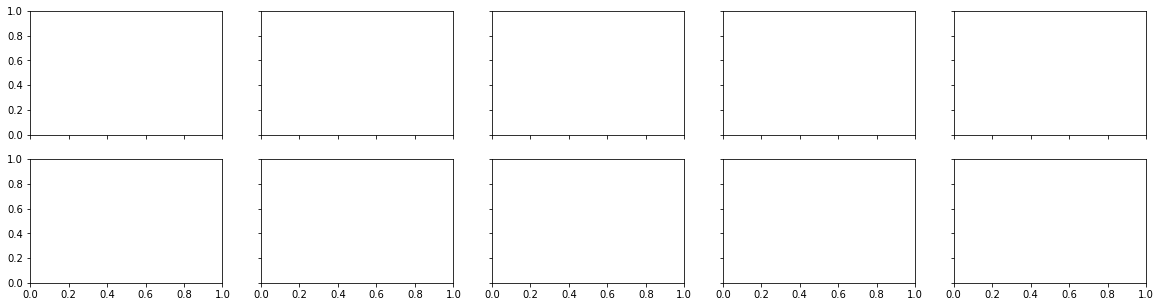

In [9]:
fig, axes = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(20, 5))
with ASDFDataSet("force_verticale.h5", mode="r") as ex2ddir,\
    ASDFDataSet("output/receivers.h5", mode="r") as salvus:
    plot_asdf_seismograms(salvus, axes)
    plot_asdf_seismograms(ex2ddir, axes)

In [10]:
# Initialize first-order absorbing boundary conditions.
boundaries = AbsorbingBoundary(
    side_sets=["x0", "x1", "y0"], 
    taper_amplitude=0.0, width_in_meters=0.0)

# Associate boundaries with our simulation.
simulation.add_boundary_conditions(boundaries)
simulation.validate()

Job `job_1903281226_c1bc7` running on `aug04` with 2 rank(s).
Site information:
  * Salvus version: 0.8.2
  * Floating point size: 32



Results have been downloaded to `output`.


OSError: Unable to open file (unable to open file: name = 'force_verticale.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

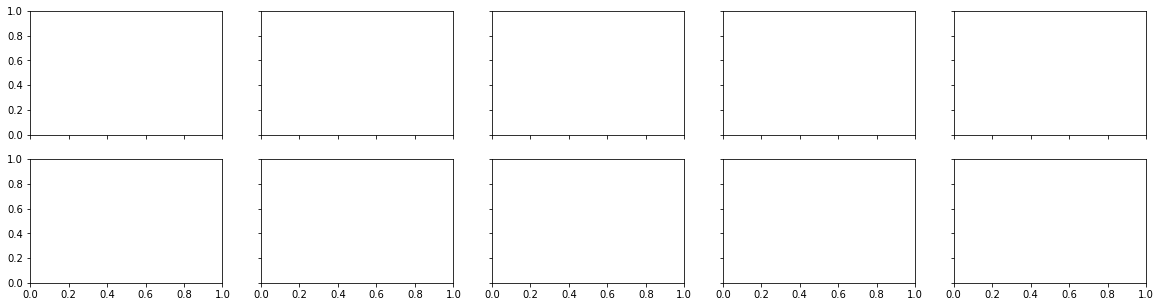

In [11]:
# Run a job.
salvus_flow.api.run(
    site_name="aug04", output_folder="output",
    input_file=simulation, ranks=2, get_all=True,
    overwrite=True)

# Plot results.
fig, axes = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(20,5))
with ASDFDataSet('output/receivers.h5', mode="r") as salvus,\
    ASDFDataSet('force_verticale.h5', mode="r") as analytic:

    # Plot.
    plot_asdf_seismograms(analytic, axes)
    plot_asdf_seismograms(salvus, axes)

    # Ensure seismograms are similar.
    for ana, sal in zip(analytic.waveforms, salvus.waveforms):
        for cmp in ["X", "Y"]:
            ana_trace = ana.displacement.select(component=cmp)[0].data[250:450]
            sal_trace = sal.displacement.select(component=cmp)[0].data[250:450]
            assert np.linalg.norm(ana_trace - sal_trace) < 1e-3

In [12]:
# NBVAL_SKIP
# Write the input file as a toml.
with open("sample_toml_file.toml", "w") as fh:
    toml.dump(simulation.get_dictionary(), fh)

# Look at the file we've written.
!cat "sample_toml_file.toml"

[domain]
dimension = 2
polynomial-order = 4

[domain.mesh]
filename = "/tmp/salvus_flow_htcbn80k/mesh.h5"
format = "hdf5"

[domain.model]
filename = "/tmp/salvus_flow_htcbn80k/mesh.h5"
format = "hdf5"

[domain.geometry]
filename = "/tmp/salvus_flow_htcbn80k/mesh.h5"
format = "hdf5"

[output.meta-data]
meta-json-filename = "info.json"

[output.point-data]
filename = "receivers.h5"
format = "asdf"
sampling-interval-in-time-steps = 1
[[output.point-data.receiver]]
location = [ 1010.0, 800.0,]
network-code = "XX"
station-code = "000"
location-code = ""
fields = [ "displacement",]

[[output.point-data.receiver]]
location = [ 1110.0, 800.0,]
network-code = "XX"
station-code = "001"
location-code = ""
fields = [ "displacement",]

[[output.point-data.receiver]]
location = [ 1210.0, 800.0,]
network-code = "XX"
station-code = "002"
location-code = ""
fields = [ "displacement",]

[[output.point-data.receiver]]
location = [ 1310.0, 800.0,]
network-code = "XX"
station-code = "003"
location-code = "